# FAST-UAV - Multirotor Design Optimization with Off-The-Shelf components

In this notebook, we will see how to achieve a design optimization using real off-the-shelf components instead of estimation models.

## 1. Setting up a problem with off-the-shelf components

In [3]:
import os.path as pth
import openmdao.api as om
import logging
import shutil
import fastoad.api as oad
from time import time
import matplotlib.pyplot as plt
import cma
from fastuav.utils.drivers.cmaes_driver import CMAESDriver
from fastuav.utils.postprocessing.analysis_and_plots import *

plt.rcParams["figure.figsize"] = 16, 8
plt.rcParams.update({"font.size": 13})

DATA_FOLDER_PATH = "../data"
CONFIGURATIONS_FOLDER_PATH = "../configurations"
WORK_FOLDER_PATH = "./workdir"

CONFIGURATION_FILE = pth.join(WORK_FOLDER_PATH, "multirotor_mdo_discrete.yaml")
SOURCE_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")

# For having log messages display on screen
logging.basicConfig(level=logging.INFO, format="%(levelname)-8s: %(message)s")

# For using all screen width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
oad.generate_configuration_file(
    CONFIGURATION_FILE, overwrite=True, distribution_name="fastuav", sample_file_name="multirotor_mdo_discrete.yaml"
)

INFO    : Loading FAST-OAD plugin uav
INFO    : Loading bundles from fastuav.models
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_hybrid (ID 13 )
INFO    : Installed bundle fastuav.models.mtow.mtow (ID 20 )
INFO    : Installed bundle fastuav.models.scenarios.wing_loading.wing_loading (ID 84 )
INFO    : Installed bundle fastuav.models.aerodynamics.__init__ (ID 15 )
INFO    : Installed bundle fastuav.models.mtow.mtow_fixedwing (ID 21 )
INFO    : Installed bundle fastuav.models.propulsion.energy.battery.catalogue (ID 38 )
INFO    : Installed bundle fastuav.models.propulsion.esc.catalogue (ID 45 )
INFO    : Installed bundle fastuav.models.scenarios.__init__ (ID 86 )
INFO    : Installed bundle fastuav.models.stability.static_longitudinal.center_of_gravity.__init__ (ID 92 )
INFO    : Installed bundle fastuav.models.aerodynamics.aerodynamics_multirotor (ID 14 )
INFO    : Installed bundle fastuav.models.propulsion.esc.constraints (ID 46 )
INFO    : Installed bundle fastua

'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\multirotor_mdo_discrete.yaml'

The changes in the model rely in the use of catalogues instead of continuous estimation models to select the components. This is described in the configuration file by the `off_the_shelf` option when defining the model:

```yaml
model:
    scenarios:
        id: fastuav.scenarios.multirotor
    propulsion:
        id: fastuav.propulsion.multirotor
        off_the_shelf_propeller: True
```

You can check with the N2 diagram visualization that the `catalogue_selection` module has replaced the `skip_catalogue_selection` module for components where the option has been set to True.

In [5]:
N2_FILE = pth.join(WORK_FOLDER_PATH, "n2.html")
oad.write_n2(CONFIGURATION_FILE, N2_FILE, overwrite=True)
from IPython.display import IFrame
IFrame(src=N2_FILE, width="100%", height="500px")

INFO    : N2 diagram written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\n2.html


Now, the problem outputs from the design optimization in the continuous domain will be re-used as an initial guess for the optimization in the discrete domain.

In [6]:
oad.generate_inputs(CONFIGURATION_FILE, SOURCE_FILE, overwrite=True)

INFO    : Problem inputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_inputs.xml


'D:\\THESE\\Tools\\FAST-UAV\\src\\fastuav\\notebooks\\workdir\\problem_inputs.xml'

In [7]:
INPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_inputs.xml")
oad.variable_viewer(INPUT_FILE)

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


## 3. Multirotor MDO with off-the-shelf components

Due to the non-continuous nature of the selection process, the use of a gradient-based algorithm is risky. We therefore recommend the use of an evolutionary algorithm, [CMA-ES](http://www.cmap.polytechnique.fr/~nikolaus.hansen/cmaesintro.html).

### a) Using a gradient-based algorithm: SLSQP

In [8]:
optim_problem = oad.optimize_problem(CONFIGURATION_FILE, overwrite=True)

Optimization terminated successfully    (Exit mode 0)
            Current function value: [1.48691983]
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization Complete
-----------------------------------


INFO    : Computation finished after 1.45 seconds
INFO    : Problem outputs written in D:\THESE\Tools\FAST-UAV\src\fastuav\notebooks\workdir\problem_outputs.xml


### b) Using an evolutionnary strategy: CMA-ES
The [pycma](https://github.com/CMA-ES/pycma) implementation of CMA-ES is used. The optimizer is wrapped with a modified version of the [OpenMDAO driver](https://github.com/OpenMDAO/RevHack2020/tree/master/problems/cma_es).<br>

*Note that the use of custom-made drivers is not supported yet by FAST-OAD. Consequently, the setup and run of the problem is made by hand.*

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 11 (seed=626615, Mon May  2 16:40:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 5.920827650236306e+05 1.0e+00 9.27e-02  9e-02  9e-02 0:00.1
    2     22 4.915089615230442e+05 1.2e+00 9.34e-02  9e-02  1e-01 0:00.2
    3     33 5.372476636073586e+05 1.3e+00 9.04e-02  8e-02  9e-02 0:00.2
   42    462 2.422969045578561e+04 8.0e+00 3.29e-02  7e-03  4e-02 0:03.2
   92   1012 1.578535046296118e+00 3.2e+01 1.04e-02  7e-04  2e-02 0:07.3
  100   1100 1.563242836623196e+00 4.2e+01 8.17e-03  4e-04  1e-02 0:07.9
  174   1914 1.509600114639237e+00 7.1e+01 3.90e-03  2e-04  6e-03 0:14.0
  200   2200 1.499733423282925e+00 1.0e+02 5.89e-03  2e-04  1e-02 0:16.1
  300   3300 1.495488298248681e+00 8.7e+01 3.89e-04  2e-05  5e-04 0:23.7
  400   4400 1.493517603917763e+00 3.7e+02 1.21e-03  3e-05  2e-03 0:31.6
  500   5500 1.488259743023609e+00 7.4e+02 4.65e-03  9e-05  9e-03 0:40.0
  600   6600 1.487337340886376e+0

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\cma\utilities\utils.py:343: UserWarning: CAVE: restart_from_best is often not useful ()
  warnings.warn(msg + ' (' +


    2   8878 7.210824570948852e+04 1.2e+00 7.61e-02  7e-02  8e-02 0:00.3
    3   8900 2.121022654530656e+05 1.2e+00 7.80e-02  6e-02  8e-02 0:00.5
   21   9296 1.570638591523116e+04 5.7e+00 2.35e-02  5e-03  3e-02 0:03.5
   46   9846 1.503406427070262e+00 2.7e+01 7.40e-03  5e-04  9e-03 0:07.6
   76  10506 1.493998427914751e+00 5.7e+01 4.13e-03  2e-04  6e-03 0:12.6
  100  11034 1.491617193251889e+00 6.8e+01 2.68e-03  1e-04  4e-03 0:16.6
  144  12002 1.488226727115863e+00 1.6e+02 3.58e-03  9e-05  8e-03 0:23.7
  192  13058 1.487669628357060e+00 4.7e+02 1.21e-03  4e-05  3e-03 0:31.8
  200  13234 1.487640616849367e+00 5.9e+02 7.66e-04  2e-05  2e-03 0:33.1
  257  14488 1.487512785609740e+00 1.3e+03 7.31e-04  1e-05  1e-03 0:43.1
  300  15434 1.487404484574306e+00 2.0e+03 2.56e-03  2e-05  5e-03 0:51.1
  365  16864 1.487302357876233e+00 4.7e+03 1.84e-03  8e-06  3e-03 1:03.3
  400  17634 1.487271952972263e+00 8.6e+03 2.59e-03  9e-06  5e-03 1:09.6
  490  19614 1.487116898513305e+00 1.1e+04 7.90e-03

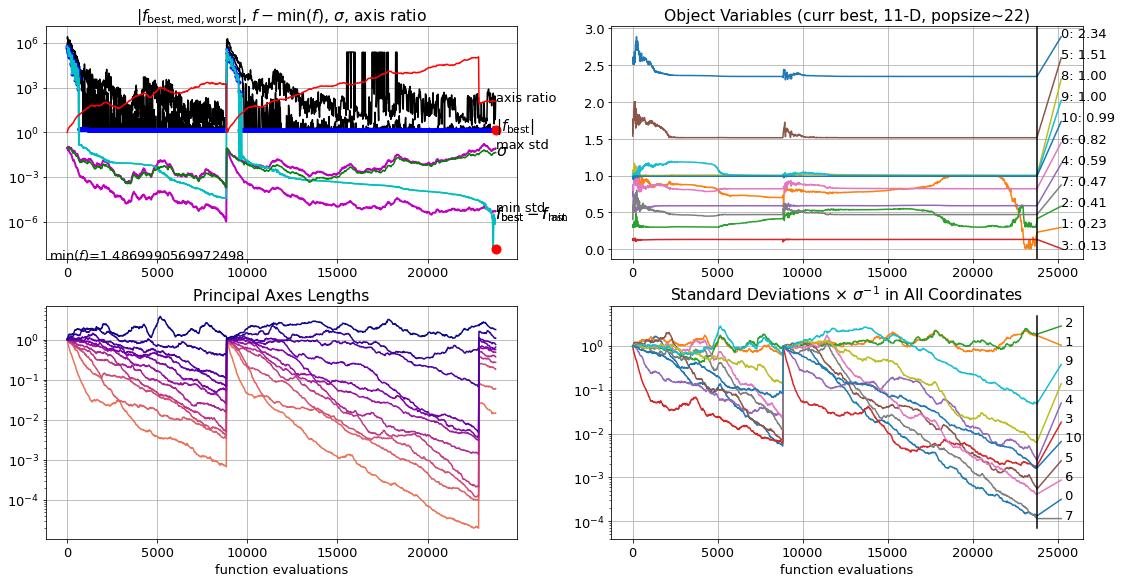

In [9]:
# Get problem configuration
conf = oad.FASTOADProblemConfigurator(CONFIGURATION_FILE)
prob = conf.get_problem(read_inputs=True, auto_scaling=True)

# CMA-ES Driver setup (see cma.CMAOptions() for all possible options for CMA-ES)
driver = prob.driver = CMAESDriver()
driver.options["sigma0"] = 0.1
driver.options[
    "penalty_parameter"
] = 1.0e6  # should be chosen such that f and the constraints violation have a similar magnitude.
driver.options["penalty_exponent"] = 1.0
driver.options["restarts"] = 1
driver.options["restart_from_best"] = True
driver.options["bipop"] = False
driver.CMAOptions["tolfun"] = 1e-6
driver.CMAOptions["tolfunhist"] = 1e-5
driver.CMAOptions["popsize_factor"] = 1
# driver.CMAOptions['CMA_stds'] = [1, 1, 100, 0.1, 0.1, 1, 1, 1, 1]
# driver.CMAOptions['CSA_dampfac'] = 1.  # positive multiplier for step-size damping
# driver.CMAOptions['CSA_squared'] = True
# driver.CMAOptions['integer_variables'] = [2]
# driver.options['augmented_lagrangian'] = True  # whether to use penalty method or augmented lagrangian for handling constraints

# Setup and run problem
prob.setup()
start_time = time()
prob.optim_failed = prob.run_driver()  # optimize
end_time = time()
computation_time = round(end_time - start_time, 2)
prob.write_outputs()

print("Objective function value ", driver.get_objective_values())

logger = cma.plot()  # plot logger

Let's save and visualize the optimization results:

In [15]:
OUTPUT_FILE = pth.join(WORK_FOLDER_PATH, "problem_outputs.xml")
DJI_M600_OUTPUT_FILE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
shutil.copy(OUTPUT_FILE, DJI_M600_OUTPUT_FILE)
oad.optimization_viewer(CONFIGURATION_FILE)

D:\Softwares\poetry\cache\virtualenvs\fastuav-qz6dlUbG-py3.8\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [16]:
oad.variable_viewer(OUTPUT_FILE)

## 3. Analysis and plots

We may now compare the results from the optimization in the continuous domain with the off-the-shelf configuration:

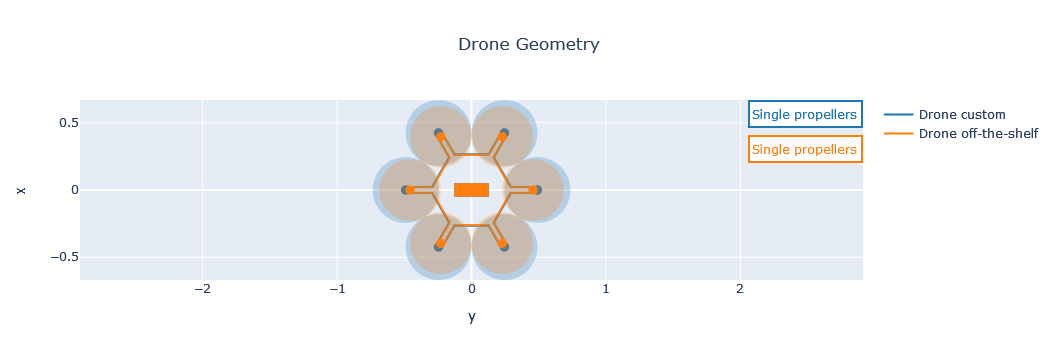

In [17]:
OUTPUT_FILE_CONTINUOUS = pth.join(DATA_FOLDER_PATH, "problem_outputs_DJI_M600_mdo.xml")
OUTPUT_FILE_DISCRETE = pth.join(DATA_FOLDER_PATH, "problem_outputs_discrete_DJI_M600_mdo.xml")
fig = multirotor_geometry_plot(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
fig = multirotor_geometry_plot(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
fig.show()

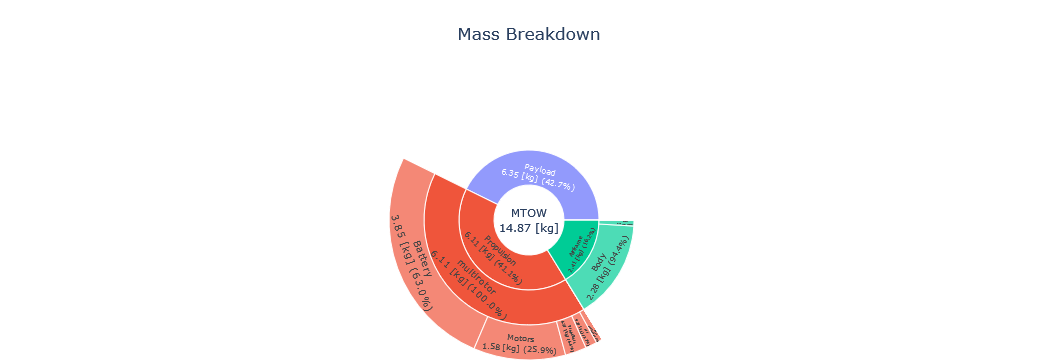

In [18]:
fig = mass_breakdown_sun_plot_drone(OUTPUT_FILE_DISCRETE)
fig.show()

In [14]:
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_CONTINUOUS, name="Drone custom")
#fig = mass_breakdown_bar_plot_drone(OUTPUT_FILE_DISCRETE, name="Drone off-the-shelf", fig=fig)
#fig.show()